In [24]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize
import stfio
from analysis_helpers import *

In [2]:
filebase = '/home/kernfel/Documents/Data/Oocytes/2017_12_06_%04d.atf'
fileno, fileno2 = 0, 1
savebase = filebase[:-4] % fileno + '-' + str(fileno2)
params = dict()
tres = 0.025 # Time of one sample in ms

Notes tell me that until 2017-12-06_0018, the current scale was set incorrectly, such that one unit of current in the file corresponds to 2 μA. We can fix that right here:

In [3]:
rec = read_2channel_ATF(filebase % fileno, current_factor = 0.5)
rec2 = read_2channel_ATF(filebase % (fileno2), current_factor = 0.5)

To make sure we've got the right recordings, let's visualise the full trace stacks:

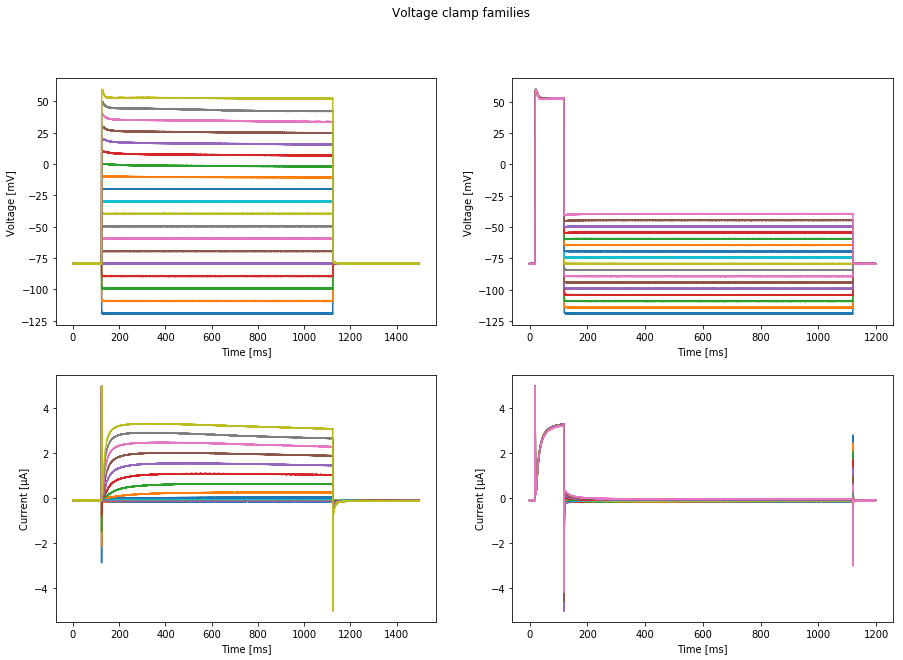

In [4]:
fig = plt.figure(figsize=(15,10))
fig.suptitle('Voltage clamp families')

t = np.arange(len(rec.voltage[0])) * tres
t2 = np.arange(len(rec2.voltage[0])) * tres

plt.subplot(2,2,1)
for V in rec.voltage:
    plt.plot(t, V)
plt.ylabel('Voltage [mV]')
plt.xlabel('Time [ms]')

plt.subplot(2,2,2)
for V in rec2.voltage:
    plt.plot(t2, V)
plt.ylabel('Voltage [mV]')
plt.xlabel('Time [ms]')

plt.subplot(2,2,3)
for I in rec.current:
    plt.plot(t, I)
plt.ylabel(u'Current [μA]')
plt.xlabel('Time [ms]')

plt.subplot(2,2,4)
for I in rec2.current:
    plt.plot(t2, I)
plt.ylabel(u'Current [μA]')
plt.xlabel('Time [ms]');

fig.savefig(savebase + '.family.png')

Then, fit the leak current to the first family by looking at the lower end of the steps:

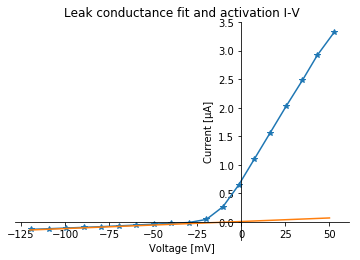

In [5]:
# The start and end of the step, with some room for the capacitive current to dissipate:
rec_limits = (5200, 44800)

fig, ax = plt.subplots()
fit_leak(rec, params, ax, rec_limits)

plt.title('Leak conductance fit and activation I-V')
plt.savefig(savebase + '.leak_IV.png')

Next, fit the potassium conductance to the tail currents of the second protocol:

In [6]:
fit_tails(rec2, params, 4760, 40000)

([2959.250424097537,
  2360.394604038671,
  1435.02402168175,
  559.848464793933,
  389.5265751303725,
  356.99477316482586,
  361.5803188092212,
  389.4912560384075,
  451.2884702731388,
  558.754076499311,
  903.2521232447714,
  7999.388751847959,
  465.6607379104541,
  664.7357505103068,
  889.2451801588333,
  1197.8459640909703,
  1674.365568465017],
 [-0.0548288875230222,
  -0.05836857668865566,
  -0.07432871575728739,
  -0.13639795997278936,
  -0.1841639914444309,
  -0.20090205142114886,
  -0.1976617839329177,
  -0.1767646769084817,
  -0.14186768644102946,
  -0.09660783453804801,
  -0.043226814694139234,
  -0.002962837841087179,
  0.08264130440101723,
  0.15173593587062018,
  0.22061566983050393,
  0.2886551520481764,
  0.3518383403006097])

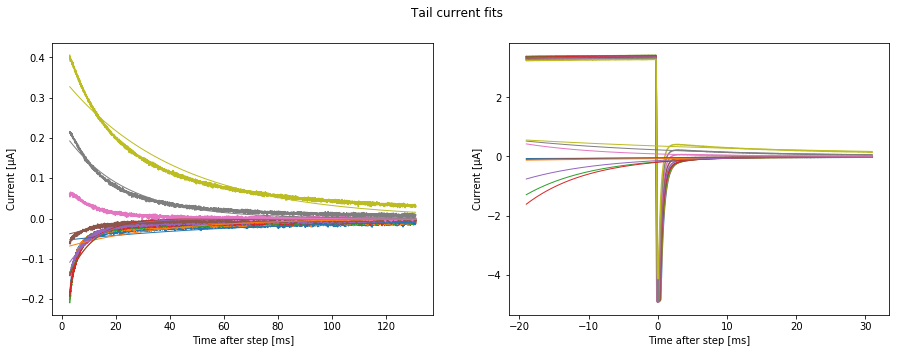

In [7]:
fig = plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)
plot_tail_fit(rec2, params, rec2.tail_cut, 10000, tres, range(0, len(rec2.tails), 2))

plt.subplot(1,2,2)
plot_tail_fit(rec2, params, 4000, 6000, tres, range(0, len(rec2.tails), 2))

fig.suptitle('Tail current fits')
fig.savefig(savebase + '.tail_fits.png')

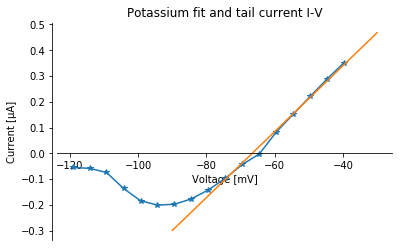

In [8]:
tail_t0 = [exp_decay(0, rec2.tau[i], rec2.a[i]) for i in range(len(rec2.tails))]

fig, ax = plt.subplots()
IVplot(tail_t0, rec2.tail_voltages, ax)

tail_fit_from = np.count_nonzero(map(lambda V: V < -80, rec2.tail_voltages))
fit_IV(tail_t0[tail_fit_from:], rec2.tail_voltages[tail_fit_from:], params, 'K')

tail_plot_V = np.array([-90, -30])
ax.plot(tail_plot_V, params['I_K'](tail_plot_V))

ax.set_title('Potassium fit and tail current I-V')
plt.savefig(savebase + '.tail_IV.png')

So, we have a valid, sensible E_K. Let's go back to the first protocol and turn that I-V into an activation curve!

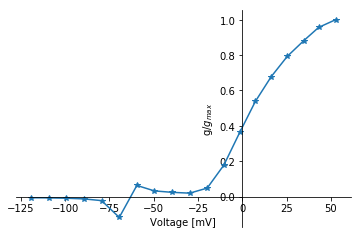

In [56]:
median_voltages = [np.median(V[rec_limits[0]:rec_limits[1]]) for V in rec.voltage]
peak_currents = [np.max(rec.current[i][rec_limits[0]:rec_limits[1]]) - params['I_leak'](median_voltages[i])
                 for i in range(len(rec.current))]

gK = [peak_currents[i] / (median_voltages[i] - params['E_K']) for i in range(len(peak_currents))]
positive_V = np.count_nonzero(map(lambda V: V>0, median_voltages))
gMax = max(gK[-positive_V:])
g_norm = np.array(gK) / gMax

fig, ax = plt.subplots()
IVplot(g_norm, median_voltages, ax, Ilabel='g/$g_{max}$')

The kinks near E_K are an artifact of noise, of course. What's striking about the shape is that it doesn't seem to fully activate until well over 50 mV!
This isn't quite the activation curve I'd like to see yet, however: after all, I'd like to see the activation variable, not the conductance. To get that, we assume that the peak current in each trace is 95% of the steady-state current defined by
$$I_{\infty} = \bar{g} n_{\infty}^4 (V-E_K)$$
and that $g_{max} = 0.95 \bar{g}$, which gives
$$n^4 = \frac {I_{\infty}} {\bar{g} (V-E_K)} = \frac {I_{max}} {g_{max} (V-E_K)}$$

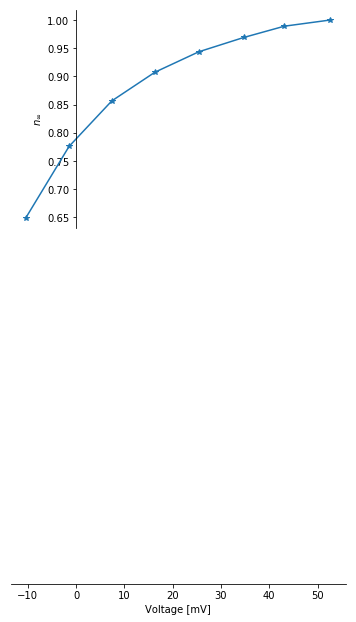

In [61]:
# Only show the top end, where g/gmax > 10% -- below that, it gets noisy and messy, because peaks aren't
# reliably detectable any longer.
for i in range(len(g_norm)):
    if n_inf[-i-1] < 0.1:
        break
min_peak = len(g_norm) - i

fig, ax = plt.subplots()
IVplot(np.power(g_norm[min_peak:], 0.25), median_voltages[min_peak:], ax, Ilabel='$n_{\\infty}$')

Now that is a nice (top half of a) sigmoid! Can we also find tau?

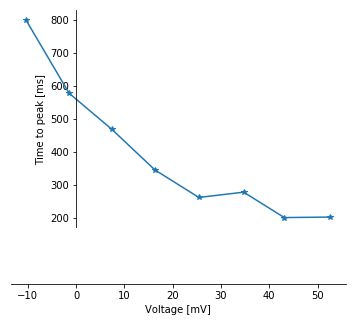

In [58]:
t0 = 4937 # See Kv2.1 exploratory analysis 1
peak_current_t = [tres * (np.argmax(I[rec_limits[0]:rec_limits[1]]) + rec_limits[0] - t0) for I in rec.current]

fig, ax = plt.subplots()
IVplot(peak_current_t[min_peak:], median_voltages[min_peak:], ax, Ilabel='Time to peak [ms]')

In [9]:
print filebase % fileno
print filebase % fileno2
print savebase
print 'g_leak:\t', params['g_leak'], 'mS'
print 'E_leak:\t', params['E_leak'], 'mV'
print 'g_K:\t', params['g_K'], 'mS'
print 'E_K:\t', params['E_K'], 'mV'
print

/home/kernfel/Documents/Data/Oocytes/2017_12_06_0000.atf
/home/kernfel/Documents/Data/Oocytes/2017_12_06_0001.atf
/home/kernfel/Documents/Data/Oocytes/2017_12_06_0000-1
g_leak:	0.0012417884392659428 mS
E_leak:	-4.234642419379304 mV
g_K:	0.012786155161595116 mS
E_K:	-66.59936654082945 mV

